# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.415459,True,5.799093
1,0.334721,True,4.738879
2,-0.289360,False,0.107189
3,-1.550413,False,-3.514540
4,0.818152,True,6.810155
...,...,...,...
995,0.869129,True,7.909926
996,0.226481,True,4.976793
997,1.792011,True,9.459240
998,0.565547,True,7.719504


<AxesSubplot:xlabel='v0'>

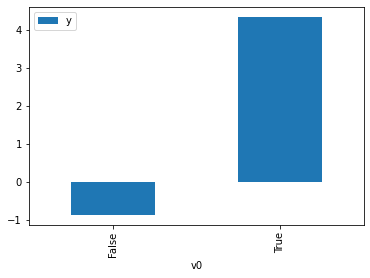

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

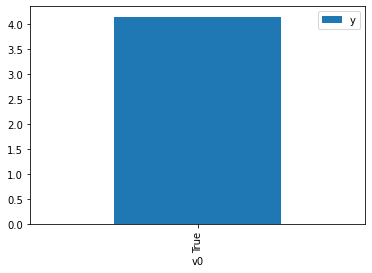

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.738449,False,-1.293852,0.594805,1.681224
1,1.064900,False,1.429020,0.351070,2.848432
2,1.193779,False,1.581592,0.334996,2.985113
3,-0.700085,False,-0.364117,0.589677,1.695844
4,1.501834,False,3.127222,0.298135,3.354181
...,...,...,...,...,...
995,0.645108,False,2.251881,0.405651,2.465171
996,0.066876,False,1.359433,0.484529,2.063861
997,0.540318,False,2.166699,0.419709,2.382602
998,-1.224705,False,-1.431520,0.657691,1.520471


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.861748,True,4.624594,0.388858,2.571631
1,-0.333312,True,3.819947,0.460182,2.173054
2,0.562837,True,6.298315,0.583324,1.714314
3,-0.459990,True,3.839200,0.442819,2.258261
4,-2.782892,True,-0.729358,0.180122,5.551786
...,...,...,...,...,...
995,-1.085406,True,2.097157,0.359873,2.778757
996,-0.290056,True,3.834698,0.466135,2.145301
997,0.235651,True,3.214793,0.538754,1.856136
998,-1.274561,True,2.190116,0.336124,2.975097


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                              7173.
Date:                Thu, 21 Jul 2022   Prob (F-statistic):                        0.00
Time:                        08:43:42   Log-Likelihood:                         -1394.5
No. Observations:                1000   AIC:                                      2793.
Df Residuals:                     998   BIC:                                      2803.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7913      0.028     63.567      0.000       1.736       1.847
x2             5.0130      0.047    107.755      0.000       4.922       5.104
==============================================================================
Omnibus:                        0.639   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.726   Jarque-Bera (JB):                0.680
Skew:                          -0.060   Prob(JB):                        0.712
Kurtosis:                       2.956   Cond. No.                         1.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""